## Prerequisites

In [1]:
import numpy as np
import pandas as pd
import keras, os, pickle
import  matplotlib.pyplot as plt
from sklearn.metrics import r2_score, confusion_matrix, plot_confusion_matrix

from sklearn.ensemble import RandomForestRegressor
from keras.models import load_model, model_from_json
from time import time

random_seed = 2019
np.random.seed(random_seed)

Using TensorFlow backend.


In [2]:
# first we need to prepare each fp as a feature vector
Fingerprints={} # this contains one list per fingerprint - not efficient...
with open('Compound_Fingerprints_155K.tab', 'r') as f:
# with open('/data/sitella/kalantzi/ChEMBL/Compound_Fingerprints.tab', 'r') as f:
    header = f.readline()
    for line in f:
        # each line is Comp-ID, SMILES, FP
        tokens = line.split()
        # we keep only those compounds which have FPs
        if tokens[2] != 'NOFP':
            fp = [int(c) for c in tokens[2] ]
            Fingerprints[ tokens[0] ] = fp
print("%d fingerprints were loaded!" % len(Fingerprints))

# load the training data - this is needed only for getting the list with ORDERED target-IDs
# as in most experiments, proteins are ordered wrt to size of train-set
Interactions_train = []    
with open("interactions_kinases_IC50_train.tab",'r') as f:
    header_line = next(f)
    for line in f:
        tokens = line.split()
        # 'Target-ID', 'Compound-ID', 'pIC50'  
        Interactions_train.append( [tokens[0], tokens[1], -np.log(float(tokens[2])) ])

# we use a dataframe to quickly sort targets wrt #compounds:
DF = pd.DataFrame( Interactions_train, columns =['Target-ID', 'Compound-ID','Std-value']) 
temp = DF.groupby(['Target-ID']).agg('count').sort_values(by='Compound-ID') # count the number of molecules
Targets = list(temp.index)
Compounds = np.unique(DF['Compound-ID'])
del temp, DF # no longer needed.

nT=len(Targets); nC=len(Compounds)
print("Trainset: {0} targets and {1} compounds are currently loaded.".format(nT,nC))

Labels_Targ = dict()
indx=0
for x in Targets:
    Labels_Targ[x]=indx
    indx+=1
    
Labels_Comp = dict()
indx=0
for x in Compounds:
    Labels_Comp[x]=indx
    indx+=1

Interactions_test = [] # first time to load - no possibility for "data contamination"
with open("interactions_kinases_IC50_test.tab", 'r') as file:
    header_line = next(file)
    for line in file:
        tokens =  line.split()
        Interactions_test.append( [tokens[0], tokens[1], -np.log(float(tokens[2])) ])
Compounds_to_test = set( [x[1] for x in Interactions_test] )
print("Test set: {0} compounds and {1} interactions are loaded.".format(len(Compounds_to_test), len(Interactions_test)))

155083 fingerprints were loaded!
Trainset: 110 targets and 23167 compounds are currently loaded.
Test set: 5551 compounds and 6264 interactions are loaded.


## Ranfom Forest - Best STL approach

Models are ready. Duration so far = -390.97962522506714
Performance for RF = 0.676504


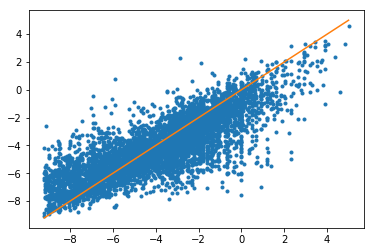

In [5]:
RF_all = {}; Y_pred = []; Y_true = []
Pertarget_RF = dict() # contains lists with tuples: (true, pred_RF, pred_NN)
Predictions_RF = [] # this will contain items as [target, compound, true, prediction]

t0=time()
for target in Targets:
    
    # define the train set
    X_train=[]; Y_train=[]
    for point in Interactions_train:
        if point[0]==target:
            X_train.append( Fingerprints[point[1]] )
            Y_train.append( float(point[2]) )
    # load pre-trained models:
    with open( 'ECFP/TrainedModels/RF_'+target+'_'+'pIC50new.sav', 'rb') as f:
        RFR = pickle.load( f )
    RFR.fit(X_train,Y_train)
    RF_all[target] = RFR
           
print("Models are ready. Duration so far =",time()-t0)
for tokens in Interactions_test:
    # 'Target-ID', 'Compound-ID', 'Std-value'  
    if tokens[1] in Fingerprints:
        Y_true.append( tokens[2] )
        x_test = np.array( Fingerprints[tokens[1]] ).reshape(1,-1) # prepare for prediction

        model = RF_all[tokens[0]]
        Y_pred.append( model.predict( x_test ) )
        Predictions_RF.append( [tokens[0], tokens[1], tokens[2], Y_pred[-1][0]] )

    if tokens[0] in Pertarget_RF:
        Pertarget_RF[tokens[0]].append( (Y_true[-1], Y_pred[-1][0])  )
    else:
        # first time for this protein
        Pertarget_RF[tokens[0]] = [ (Y_true[-1], Y_pred[-1][0]) ]

print("Performance for RF = %f" % r2_score( Y_true, Y_pred ))
plt.plot(Y_true, Y_pred,'.')
plt.plot([min(Y_true), max(Y_true)], [min(Y_true), max(Y_true)])

In [6]:
Scores_RF_pertarget = []
for target in Pertarget_RF:
    true=[]; pred=[]; 
    # aggregate predictions
    for point in Pertarget_RF[target]:
        true.append( point[0] )
        pred.append( point[1] )
    # calculate performance for each method
    r2 = r2_score(true, pred)
    Scores_RF_pertarget.append( r2 )
print("Mean per target R2-score for RF = {0:.4f} and std = {1:.4f}".format( np.mean(Scores_RF_pertarget), np.std(Scores_RF_pertarget) )) 

Mean per target R2-score for RF = 0.5263 and std = 0.1955


## Neural Network with MTL approach

In [11]:
from time import time
import keras 
import keras.backend as K
from keras import regularizers, Model
from keras.layers import Dense

def masked_loss_function(y_true, y_pred):
    mask = K.cast(K.not_equal(y_true, 10), K.floatx())
    return keras.losses.mean_squared_error(y_true * mask, y_pred * mask)

def MTL(lamda=0.02, wsl=200, whl=20, lr=0.0001):
    inputs = keras.Input(shape=(2048,))
    sharedlayer = keras.layers.Dense(wsl, activation='tanh',kernel_regularizer=regularizers.l2(lamda) )(inputs) 
    myinit = keras.initializers.Constant(-4.)
    hidden = []
    for i in range(len(Targets)):
        hl = Dense(units=whl,  activation='tanh', kernel_regularizer=regularizers.l2(lamda) )(sharedlayer)
        hidden.append( Dense(1, kernel_initializer=myinit, activity_regularizer=regularizers.l1(0.0001) )(hl) )

    MTL=Model(inputs=inputs, outputs=hidden)
    MTL.compile(loss=masked_loss_function, optimizer=keras.optimizers.adam(lr=0.0001))
    return MTL

Interactions_train = []    
with open("interactions_kinases_IC50_train.tab",'r') as f:
    header_line = next(f)
    for line in f:
        tokens = line.split()
        # 'Target-ID', 'Compound-ID', 'pIC50'  
        Interactions_train.append( [tokens[0], tokens[1], -np.log(float(tokens[2])) ])

# Initialize sparse matrix - this will be binary
DTI = 10*np.ones((nC,nT),dtype=float)
for edge in Interactions_train:
    # each edge has "target-compound-value-active"
    DTI[ Labels_Comp[edge[1]], Labels_Targ[edge[0]] ] = edge[2]
    
Nepochs = 50; BS=128
t0=time()
MTLR = MTL(wsl=200, whl=20, lamda=0.02 )
MTLR.fit( np.array([Fingerprints[x] for x in Compounds]), [x for x in DTI.T], epochs=Nepochs, batch_size=BS, verbose=0, use_multiprocessing=True )
print("Training length with {0} epochs and BS={1} is {2}".format(Nepochs, BS, time()-t0))


Training length with 50 epochs and BS=128 is 1009.9733266830444


Performance for MTL NN = 0.595285


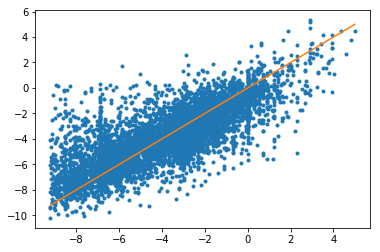

In [12]:
# pred = []; True_vals = []
Percomp = {} # contains dicts with lists: (target: [true, pred_NN] )
Predictions_MTL = []
for test_case in Compounds_to_test:
    Percomp[ test_case ] = {}
    # 
    for tokens in Interactions_test:
        if tokens[1]==test_case:
            Percomp[test_case][ tokens[0] ] = [ tokens[2] ]
            
    preds = MTLR.predict( np.array( Fingerprints[test_case]).reshape(1,-1) )

    for target in Percomp[test_case]: 
        Percomp[test_case][target].append( preds[Labels_Targ[target]][0])
        Predictions_MTL.append( [target,test_case, Percomp[test_case][target][0], Percomp[test_case][target][1][0] ])
            
Y_true = [x[2] for x in Predictions_MTL];
Y_pred = [x[3] for x in Predictions_MTL];
print("Performance for MTL NN = %f" % r2_score(Y_true, Y_pred))

plt.figure()
plt.plot(Y_true, Y_pred,'.')
plt.plot([min(Y_true),max(Y_true)], [min(Y_true),max(Y_true)])

In [13]:
Pertarget_MTL={}
for tokens in Predictions_MTL:
    if tokens[0] in Pertarget_MTL:
        Pertarget_MTL[tokens[0]].append( (tokens[2], tokens[3])  )
    else:
        # first time for this protein
        Pertarget_MTL[tokens[0]] = [ (tokens[2], tokens[3]) ]

Scores_MTL_pertarget = []

for target in Pertarget_MTL:
    true=[]; pred=[]; 
    # aggregate predictions
    for point in Pertarget_MTL[target]:
        true.append( point[0] )
        pred.append( point[1] )
    
    # calculate performance for each method
    r2 = r2_score(true, pred)
    Scores_MTL_pertarget.append( r2 )

print("Mean per target R2-score for RF = {0:.4f} and std = {1:.4f}".format( np.mean(Scores_MTL_pertarget), np.std(Scores_MTL_pertarget) )) 

Mean per target R2-score for RF = 0.3468 and std = 0.3733


### Analyse results

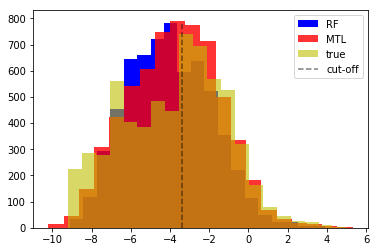

In [14]:
plt.figure()
plt.hist( [x[3] for x in Predictions_RF ], bins=20, color='b',label="RF")
plt.hist( [x[3] for x in Predictions_MTL], bins=20, color='r', alpha=0.8, label="MTL")
plt.hist( [x[2] for x in Predictions_RF ], bins=20, color='y', alpha=0.6, label='true')

plt.vlines(-np.log(30),0,780, alpha=0.5, linestyles='dashed', label="cut-off")
plt.legend(loc=1)
plt.savefig("Distr-Testset.png")
plt.show()

In [16]:
from sklearn.metrics import mean_squared_error as mse

print( mse([x[2] for x in Predictions_MTL], [x[3] for x in Predictions_MTL]) )
print( mse([x[2] for x in Predictions_RF], [x[3] for x in Predictions_RF]) )

2.835494681628459
2.2664670061144463


#### Compare methods as if we had a classification task - just an insight

Normalized confusion matrix
[[0.85122938 0.14877062]
 [0.2300885  0.7699115 ]]
Normalized confusion matrix
[[0.93930906 0.06069094]
 [0.2962963  0.7037037 ]]


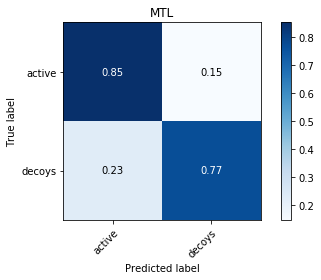

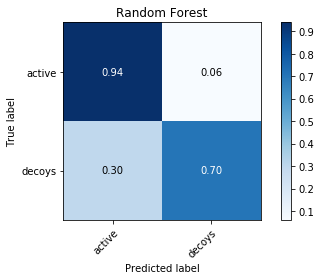

In [23]:
# ind = np.where( [x[2] for x in Predictions_MTL] >-np.log(30) )[0]
Class = []; Pred = []
for x in Predictions_MTL:
    if x[2] > -np.log(30): Class.append(1) 
    else: Class.append(0)
    if x[3] > -np.log(30): Pred.append(1) 
    else: Pred.append(0)

# confusion_matrix(Class, Pred, labels=None)
plot_confusion_matrix(Class, Pred, ['active','decoys'], title='MTL', normalize=True)

Class = []; Pred = []
for x in Predictions_RF:
    if x[2] > -np.log(30): Class.append(1) 
    else: Class.append(0)
    if x[3] > -np.log(30): Pred.append(1) 
    else: Pred.append(0)

# confusion_matrix(Class, Pred, labels=None)
plot_confusion_matrix(Class, Pred, ['active','decoys'], title='Random Forest', normalize=True)

In [10]:
# mu = np.mean([x[2] for x in Interactions_train]); sigma = np.std([x[2] for x in Interactions_train])
# print("Train set specs : {0} | {1}".format(mu, sigma))
# True_std = [ (x-mu)/sigma for x in True_vals]
# print("Performance after global standardisation  = %f" % r2_score( True_std, Pred_RF ))

# mu = np.mean(True_vals); sigma = np.std(True_vals)
# print("Test set specs  : {0} | {1}".format(mu, sigma))
# True_std = [ (x-mu)/sigma for x in True_vals]
# print("Performance after testing standardisation = %f" % r2_score( True_std, Pred_RF ))

# print("Prediction specs:  {0} | {1}".format(np.mean(Pred_RF), np.std(Pred_RF)))
# # mu = np.mean(Pred_RF); sigma = np.std(Pred_RF)